# 0. Requirements

`>> pip install git+https://github.com/openai/multiagent-particle-envs.git`

`>> pip install gym==0.10.5`

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import random
import numpy as np
from collections import deque

# 1. Environment description

There are 3 adversary agents (red), 1 nonadversary agent (green) and 2 landmarks (black). Nonadversary agent is penalized based on how far the agent is from adversary agents. Nonadversary agent get penalty if the agent collide with adversary agents. Adversary agents get reward if they collide with nonadversary agent. So, nonadversary agent have to learn to run away, and adversary agent have to learn to catch.

## 1.1 State
Each agent's state is n-dimensional state, with following components:

### 1.1.1 adversary
<center>[agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos + other_vel</center>
    
- `agent.state.p_vel` : x, y speed (2-dim)
- `agent.state.p_pos` : x, y position (2-dim)
- `entity_pos` : x, y position of landmarks (2 * 2 dim)
- `other_pos`: x, y poisition of other agents (2 * 3 dim)
- `other_vel` : x, y speed of nonadversary agent
- total 16 dimensional state

### 1.1.2 nonadversary
<center>[agent.state.p_vel] + [agent.state.p_pos] + entity_pos + other_pos</center>
    
- `agent.state.p_vel` : x, y speed (2-dim)
- `agent.state.p_pos` : x, y position (2-dim)
- `entity_pos` : x, y position of landmarks (2 * 2 dim)
- `other_pos`: x, y poisition of other agents (2 * 3 dim)
- total 14 dimensional state

## 1.2 Action

Agent's action is 5-dimensional, where each element implies the velocity of the direction:

<center>[hold, right, left, up, down]</center>

For example, if action is [0, 1, 0, 0, 1], the agent is moving to the north-east direction with speed $\sqrt{2}/\text{timestep}$ .

Nonadversary agent's maximum speed is twice of adversary agents'.

## 1.3 Reward

Modified version of the original simple-spread environment (see `simple_spread.py` file)

In [2]:
from simple_tag import Scenario

def make_env():

    from multiagent.environment import MultiAgentEnv

    # load scenario from script
    scenario = Scenario()
    
    # create world
    world = scenario.make_world()
    
    # create multiagent environment
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
        
    return env

In [3]:
env = make_env()

print("---------- environment check ----------")

print("agents' action space      : ", [a_s.n for a_s in env.action_space])

print("agents' observation space : ", [o_s.shape[0] for o_s in env.observation_space])

print("Is agent an adversary?    : ", [env.agents[i].adversary for i in range(4)])

---------- environment check ----------
agents' action space      :  [5, 5, 5, 5]
agents' observation space :  [16, 16, 16, 14]
Is agent an adversary?    :  [True, True, True, False]


# 2. Neural Networks
## 2.1 Multi-Layered-Perceptron

In [4]:
class MLP(nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_dims=[64, 64], hidden_act=nn.ReLU(), out_act=nn.Identity()):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        in_dims = [in_dim] + hidden_dims
        out_dims = hidden_dims + [out_dim]

        for _in, _out in zip(in_dims, out_dims):
            self.layers.append(nn.Linear(_in, _out))

        for i in range(len(hidden_dims)):
            self.activations.append(hidden_act)
        self.activations.append(out_act)

    def forward(self, x):
        for l, a in zip(self.layers, self.activations):
            x = l(x)
            x = a(x)

        return x

# 3. Agent

## 3.1 Replay Memory

In [5]:
class ReplayMemory:
    
    def __init__(self, length):
        self.memory = deque(maxlen=length)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, size):
        sample = random.sample(self.memory, size)

        state = [i[0] for i in sample]
        action = [i[1] for i in sample]
        reward = [i[2] for i in sample]
        next_state = [i[3] for i in sample]
        terminal = [i[4][0] for i in sample]

        return state, action, reward, next_state, terminal

## 3.2 Update model

In [6]:
def update_model(source, target, tau):
    
    for src_param, target_param in zip(source.parameters(), target.parameters()):
        target_param.data.copy_(tau * src_param.data + (1.0 - tau) * target_param.data)

## 3.3 Actor Network

In [7]:
class Actor(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()

        self.policy = MLP(state_dim, action_dim, out_act=nn.Tanh())

    def forward(self, x):
        return self.policy(x)

## 3.4 Critic Network

In [8]:
class Critic(nn.Module):
    
    def __init__(self, state_dim, action_dim, hidden_dim=32):
        super(Critic, self).__init__()
        self.bef_embed_action_net = MLP(state_dim, hidden_dim, out_act=nn.ReLU())
        self.aft_embed_action_net = MLP(hidden_dim + action_dim, 1)

    def forward(self, state, action):
        x = self.bef_embed_action_net(state)
        embed_action = torch.cat([x, action], dim=-1)
        x = self.aft_embed_action_net(embed_action)
        return x

## 3.5 DDPG Agent

In [9]:
class DDPG_Agent(nn.Module):
    
    def __init__(self, state_dim, action_dim, action_min, action_max, state_dim_all, action_dim_all, gamma=0.99):
        super(DDPG_Agent, self).__init__()
        self.action_min = np.array(action_min)
        self.action_max = np.array(action_max)

        self.gamma = gamma
        
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim_all, action_dim_all)

        self.actor_target = Actor(state_dim, action_dim)
        self.critic_target = Critic(state_dim_all, action_dim_all)

        update_model(self.actor, self.actor_target, tau=1.0)
        update_model(self.critic, self.critic_target, tau=1.0)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=0.0001)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=0.001)

        self.mse_loss = nn.MSELoss()

    def get_action(self, state, epsilon):
        action = self.actor(state).detach()

        action = torch.clamp(action + epsilon * (torch.rand(5) * 2.0 - 1.0), min=-1.0, max=1.0)
        action_norm = action * self.action_max

        return action, action_norm

    def update_target(self, tau=0.05):

        update_model(self.actor, self.actor_target, tau=tau)
        update_model(self.critic, self.critic_target, tau=tau)

## 3.6 MADDPG Agent

Pseudocode of MADDPG is as follow.

![pseudocode.png](images/pseudocode.png)

In [10]:
class MADDPG_Agent(nn.Module):
    
    def __init__(self, num_agents, state_dim, action_dim, action_min, action_max, state_dim_all, action_dim_all, gamma=0.99):
        super(MADDPG_Agent, self).__init__()
        
        self.number_of_agents = num_agents
        self.replay_memory = ReplayMemory(50000)
        self.batch_size = 50
        
        self.agents = []
        
        self.epsilon = 1.0
        self.epsilon_decay = 0.00005
        self.epsilon_min = 0.1
        
        for i in range(num_agents):
            temp_agent = DDPG_Agent(state_dim[i], action_dim[i], action_min[i], action_max[i], state_dim_all, action_dim_all, gamma)
            self.agents.append(temp_agent)
    
    def get_action(self, state):
        
        actions = []
        actions_norm = []
        
        for i in range(self.number_of_agents):
            action, action_norm = self.agents[i].get_action(state[i], self.epsilon)
            actions.append(action.detach())
            actions_norm.append(action_norm.tolist())
        
        self.epsilon -= self.epsilon_decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
        return actions, actions_norm
    
    def update_model(self):
        
        for agent_idx in range(self.number_of_agents):
            self.agents[agent_idx].update_target()
            
    def push(self, transition):
        self.replay_memory.push(transition)
    
    def train_model(self):
        
        a_loss_sum = 0.0
        c_loss_sum = 0.0
        
        if len(self.replay_memory) > self.batch_size:
            
            for agent_idx in range(self.number_of_agents):
                
                s, a, r, s_, t = self.replay_memory.sample(self.batch_size)
                
                c_target_x = []
                c_target_a = []
                
                c_x = torch.stack([torch.cat(s_elem) for s_elem in s]).type(torch.float32)
                c_a = torch.tensor(np.stack([np.concatenate(a_elem) for a_elem in a]), dtype=torch.float32)                

                c_orig_x = c_x.clone().detach()
                c_orig_a = []
                
                for batch_idx in range(batch_size):

                    x_ = s_[batch_idx]
                    x_ = torch.cat(x_)
                    c_target_x.append(x_)
                    
                    a_next_s = [self.agents[idx].actor_target(s_[batch_idx][idx]) for idx in range(4)]
                    a_next_s = torch.cat(a_next_s)
                    c_target_a.append(a_next_s)
                    
                    a_cur_s = [self.agents[idx].actor(s[batch_idx][idx]) for idx in range(4)]
                    a_cur_s = torch.cat(a_cur_s)
                    c_orig_a.append(a_cur_s)
                    
                c_target_x = torch.stack(c_target_x)
                c_target_a = torch.stack(c_target_a)
                c_orig_a = torch.stack(c_orig_a)
                
                r = torch.tensor([r_elem[agent_idx] for r_elem in r]).reshape(-1, 1)
                t = torch.tensor(t, dtype=torch.float32)
                t = (1 - t).reshape(-1, 1)
                
                # target & predicted value
                y = r + t * gamma * self.agents[agent_idx].critic_target(c_target_x, c_target_a)
                y = y.detach()
                q_value = self.agents[agent_idx].critic(c_x, c_a)
                
                # update critic network
                c_loss = self.agents[agent_idx].mse_loss(y, q_value)
                self.agents[agent_idx].critic_optimizer.zero_grad()
                c_loss.backward()
                self.agents[agent_idx].critic_optimizer.step()

                # update actor network
                a_loss = - self.agents[agent_idx].critic(c_orig_x, c_orig_a)
                a_loss = a_loss.mean()
                self.agents[agent_idx].actor_optimizer.zero_grad()
                a_loss.backward()
                self.agents[agent_idx].actor_optimizer.step()
                
                c_loss_sum += c_loss.item()
                a_loss_sum += a_loss.item()
        
        return a_loss_sum, c_loss_sum

## 3.7 Plot graphs

In [11]:
def plot_graph(data, title, file_name):
    plt.plot(data)
    plt.title(title)
    plt.savefig(file_name)
    plt.close('all')

## 3.8 Define agent and envirionment

In [12]:
env = make_env()

episodes = 5
episode_max_len = 60
gamma = 0.99

number_of_agents = env.n
agents = []

batch_size = 50

state_dim = []
action_dim = []

state_dim_all = 16 * 3 + 14
action_dim_all = 5 * 4

action_min = []
action_max = []

print("---------- agents information ----------")
for i in range(number_of_agents):

    state_dim_i = env.observation_space[i].shape[0]
    action_dim_i = env.action_space[i].n

    if env.agents[i].adversary:
        action_low, action_high = [-1.0] * action_dim_i, [1.0] * action_dim_i
    else:
        action_low, action_high = [-2.0] * action_dim_i, [2.0] * action_dim_i
    
    state_dim.append(state_dim_i)
    action_dim.append(action_dim_i)
    
    action_min.append(action_low)
    action_max.append(action_high)

    print("agent %d : state dim : %d, action dim :%d" % (i, state_dim_i, action_dim_i))
print("")

Agents = MADDPG_Agent(num_agents = number_of_agents, state_dim = state_dim, action_dim = action_dim, 
                action_min = action_min, action_max = action_max, state_dim_all = state_dim_all, action_dim_all = action_dim_all, gamma = 0.9)

---------- agents information ----------
agent 0 : state dim : 16, action dim :5
agent 1 : state dim : 16, action dim :5
agent 2 : state dim : 16, action dim :5
agent 3 : state dim : 14, action dim :5



## 3.9 Train MADDPG

In [13]:
actor_loss_all = []
critic_loss_all = []

rewards = [[], [], [], []]

for epi in range(episodes):
    
    print("episode : ", epi)

    state = env.reset()
    state = [torch.tensor(s, dtype=torch.float32) for s in state]

    r = [0, 0, 0, 0]

    for time in range(episode_max_len):
        
        action, action_norm = Agents.get_action(state)
        
        next_state, reward, done, _ = env.step(action_norm)
        next_state = [torch.tensor(s, dtype=torch.float32) for s in next_state]
        
        print('{:4.4f}, {:4.4f}, {:4.4f}, {:4.4f}, epsilon : {:.4f}'.format(reward[0], reward[1], reward[2], reward[3], Agents.epsilon))
        
        for i in range(number_of_agents):
            r[i] += reward[i]

        if time + 1 == episode_max_len:
            done = [True for _ in range(Agents.number_of_agents)]

        transition = [state, action, reward, next_state, done]
        Agents.push(transition)
        state = next_state
        
        actor_loss, critic_loss = Agents.train_model()
        Agents.update_model()
        
        actor_loss_all.append(actor_loss)
        critic_loss_all.append(critic_loss)

        if all(done):
            break
    
    for i in range(number_of_agents):
        rewards[i].append(r[i])
        
    plot_graph(actor_loss_all, 'actor loss', 'images/a_loss.png')
    plot_graph(critic_loss_all, 'critic loss', 'images/c_loss.png')
    plot_graph(rewards[0], 'reward 1', 'images/reward1.png')
    plot_graph(rewards[1], 'reward 2', 'images/reward2.png')
    plot_graph(rewards[2], 'reward 3', 'images/reward3.png')
    plot_graph(rewards[3], 'reward 4', 'images/reward4.png')

episode :  0
-0.3181, -0.3181, -0.3181, 0.2002, epsilon : 1.0000
-0.3264, -0.3264, -0.3264, 0.3264, epsilon : 0.9999
-0.3440, -0.3440, -0.3440, 0.3440, epsilon : 0.9999
-0.3335, -0.3335, -0.3335, 0.3335, epsilon : 0.9998
-0.3025, -0.3025, -0.3025, 0.3025, epsilon : 0.9998
-0.3101, -0.3101, -0.3101, 0.3101, epsilon : 0.9997
-0.3156, -0.3156, -0.3156, 0.3156, epsilon : 0.9997
-0.3100, -0.3100, -0.3100, 0.3100, epsilon : 0.9996
-0.2735, -0.2735, -0.2735, 0.2735, epsilon : 0.9996
-0.2713, -0.2713, -0.2713, 0.2713, epsilon : 0.9995
-0.2632, -0.2632, -0.2632, 0.2632, epsilon : 0.9995
-0.2680, -0.2680, -0.2680, 0.2680, epsilon : 0.9994
-0.3059, -0.3059, -0.3059, 0.3059, epsilon : 0.9994
-0.3207, -0.3207, -0.3207, 0.3207, epsilon : 0.9993
-0.3315, -0.3315, -0.3315, 0.3315, epsilon : 0.9993
-0.3349, -0.3349, -0.3349, 0.3349, epsilon : 0.9992
-0.3368, -0.3368, -0.3368, 0.3368, epsilon : 0.9992
-0.3578, -0.3578, -0.3578, 0.3578, epsilon : 0.9991
-0.3756, -0.3756, -0.3756, 0.3756, epsilon : 0.9991

KeyboardInterrupt: 

# 4. Visualize

## 4.1 Visualizing state function

In [14]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def vis_state(env):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    
    # msking rectangle
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # plotting agent and landmarks
    for entity in env.world.entities:
        color = entity.color
        size = entity.size
        center = entity.state.p_pos
        draw_circle = plt.Circle(center, size, color=color)
        ax.add_artist(draw_circle)
    plt.show()
    clear_output(wait=0.1)

## 4.1 Checking the learned policy

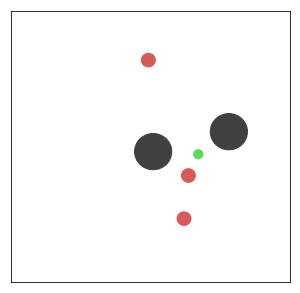

In [15]:
n_episodes = 1
max_timestep = 40
n_agents = env.n
action_dim = env.action_space[0].n



for e in range(n_episodes):
    
    t = 0
    terminated = False
    
    state = env.reset()
    state = [torch.tensor(s, dtype=torch.float32) for s in state]

    while True:             
        vis_state(env)
        t += 1
        action, action_norm = Agents.get_action(state)
        
        next_state, reward, terminated, _ = env.step(action_norm)
        
        state = next_state
        state = [torch.tensor(s, dtype=torch.float32) for s in state]
        
        if all(terminated) or t >= max_timestep:
            break